In [1]:
import pandas as pd
from statsmodels.tsa.stl.mstl import MSTL
import main
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt

ercot = main.build_ercot_load()

In [2]:
train = ercot[ercot["DATETIME"].dt.year < 2023]

mstl = MSTL(train.set_index("DATETIME")["ERCOT"],
            periods=[24, 24 * 7, 365 * 24], iterate=3, windows=[11, 15, 9999],
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})

res = mstl.fit()

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform((res.trend + res.resid).values.reshape(-1, 1))

# generate the training sequences
n_forecast = 24 * 3
n_lookback = 24 * 3

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mse', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

X_ = y[- n_lookback:]
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

model.save(f"{n_lookback}-{n_forecast}-lstm-single-forecast.hd5")

KeyboardInterrupt: 

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform((res.trend + res.resid).values.reshape(-1, 1))

# generate the training sequences
n_forecast = 1
n_lookback = 24 * 31

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=128, validation_split=0.2, verbose=0)

# generate the multi-step forecasts
n_future = 24 * 3
y_future = []

x_pred = X[-1:, :, :]  # last observed input sequence
y_pred = Y[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1, 1)
y_future = scaler.inverse_transform(y_future)

model.save(f"{n_lookback}-{n_forecast}-lstm-multi-forecast.keras")

In [ ]:
plt.plot(y_future)
plt.plot(Y_)

In [87]:
import pandas as pd
real = ercot[ercot["DATETIME"].dt.year == 2023].head(72)[["DATETIME", "ERCOT"]].reset_index(drop=True)
pred = pd.read_csv("forecast.csv")
total = pd.concat([real, pred], axis=1, ignore_index=True)
total.columns = ["DATETIME", "Actual Load", "DAY", "WEEK", "YEAR", "TREND_ERROR"]
total["LSTM Forecast"] = pred.sum(axis=1)
total["SVR"] = pd.read_csv("svr_preds.csv")["svr"]
total["ARIMA"] = pd.read_csv("error_trend_arima_forecast.csv")["arima_error_trend"]
total["ERCOT Forecast"] = pd.read_csv("ercot_forecast_jan.csv")["total"]
total.set_index("DATETIME", inplace=True)
total["SVR Forecast"] = total[["YEAR", "WEEK", "DAY", "SVR"]].sum(axis=1)
total["ARIMA Forecast"] = total[["YEAR", "WEEK", "DAY", "ARIMA"]].sum(axis=1)

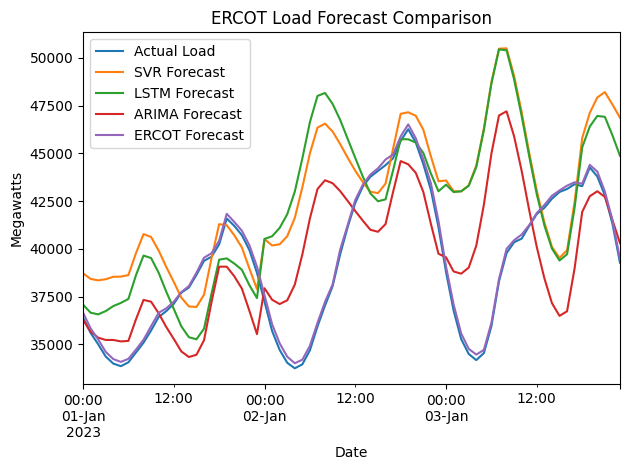

In [89]:
total[["Actual Load", "SVR Forecast", "LSTM Forecast", "ARIMA Forecast", "ERCOT Forecast"]].plot()
plt.ylabel("Megawatts")
plt.xlabel("Date")
plt.title("ERCOT Load Forecast Comparison")
plt.tight_layout()
plt.savefig("Forecast_Comps.png")

In [82]:
from sklearn.metrics import mean_squared_error

rmse_ercot = mean_squared_error(total["ACTUAL"], total["ERCOT_FORECAST"], squared=False)
rmse_arima = mean_squared_error(total["ACTUAL"], total["ARIMA_FORECAST"], squared=False)
rmse_lstm = mean_squared_error(total["ACTUAL"], total["LSTM_FORECAST"], squared=False)
rmse_svr = mean_squared_error(total["ACTUAL"], total["SVR_FORECAST"], squared=False)

In [83]:
print(rmse_ercot, rmse_arima, rmse_lstm, rmse_svr)

216.26748846067645 3676.5056677877383 5513.958128981635 5400.985160462273


In [53]:
pd.DataFrame(outs).sort_values(by=3)

,0,1,2,3
24,4,1,4,579495.921735
23,4,1,3,579589.175553
17,3,1,2,580006.348786
13,2,1,3,580006.376252
18,3,1,3,580008.288099
22,4,1,2,580008.340821
14,2,1,4,580008.372645
19,3,1,4,580009.849213
21,4,1,1,580013.648498
12,2,1,2,580014.915169


In [55]:
mod = ARIMA(res.trend + res.resid, order=(3, 1, 2))
error_trend_arima = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')
error_trend_arima.forecast(24*3).to_csv("error_trend_arima_forecast.csv")

/Users/malcolmmoss/PycharmProjects/ercot_forecasting/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malcolmmoss/PycharmProjects/ercot_forecasting/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/malcolmmoss/PycharmProjects/ercot_forecasting/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/98/9n7hhtwj2rv2jdkkj2fmm52r0000gn/T/ipykernel_44774/69009701.py:2: UserWarning: Provided `endog` se

In [59]:
print(error_trend_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                43823
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -289997.174
Date:                Mon, 29 Apr 2024   AIC                         580006.349
Time:                        17:13:57   BIC                         580058.476
Sample:                             0   HQIC                        580022.778
                              - 43823                                         
Covariance Type:         Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5202        nan        nan        nan         nan         nan
ar.L2         -0.5315        nan        nan        nan         nan         nan
ar.L3         -0.0796        nan        nan        n